# REDES NUERONALES RECURRENTES

Implementacion con un set de sañales trigonometricas.

## Funciones comunes a todas la partes

# Ejercicio para RNN



Empleando el notebook de [predicción de serie temporal](jupyter_notebooks/RNN_signal_TP.ipynb), proponer una 
arquitectura de RNN que mejore la performance del MLP.
 Deberá contar con las siguientes características:

- Largo de entrada 50 muestras (para pasarle el mismo número de datos que al MLP).
- Predicción a futuro 10 muestras.
- Emplear el mismo paquete de datos generados (con la función `generate_time_series`) para
contar con los exactos mismos datos de entrenamiento, validación y testeo.
- Recordar que el MLP está programado para predecir 1 solo valor a futuro y
ahora deseamos predecir 10 valores a futuro!

#### Se importan librerias y se definen la generadora de serie de tiempo y la red neuronal.

In [60]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error

In [61]:
# Funcion para generar base de datos de señales
def generate_time_series(batch_size, n_steps, n_future):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps + n_future)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps + n_future) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [62]:
# función que plotea un array de curvas (inputs y outputs)
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()



In [63]:
# Clase dataset para luego armar los dataloader
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix]) # si no es train, solo devuelve el X


In [64]:
# funciones de entrenamiento

from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs+1):
        print("epoch numero: ", epoch)
        bar = tqdm(dataloader['train'])
        model.train()
        train_loss = []
        eval_loss = []
        for batch in bar:
            X, y = batch
            #print(X.shape)
            #input()
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)

            #print('y shape')
            #print(y.shape)
            y = y.view(y.shape[0], -1) # aca elimino la dim de la profundidad
            #print(y.shape)
            #print(' y hat shape')
            #print(y_hat.shape)
            
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            bar.set_description(f"train_loss {np.mean(train_loss):.5f}")
        
        bar = tqdm(dataloader['eval'])
        model.eval()
        
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                y = y.view(y.shape[0], -1)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                bar.set_description(f"valid_loss {np.mean(eval_loss):.5f}")
        
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [65]:
# función para imprimir parametros del modelo.
def imp_param(model):
  print('-'*84)
  print('PARAMETROS DEL MODELO')
  print('-'*84)
  for name, param in model.named_parameters():
    if param.requires_grad: 
      print('Nombre del parámetro: ')
      print(name)
      print('Tamaño del parámetro: ')
      print(param.data.shape)
      print()

## Primera aproximación de recurrencia, empleado un perceptrón multicapa.
(adapación de un MLP para predecir el valor futuro de un señal)



In [160]:
n_steps = 50
n_future = 10
series = generate_time_series(10000, n_steps, n_future)
X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

X and y Train shape
(7000, 50, 1) (7000, 10, 1)
X and y Valid shape
(2000, 50, 1) (2000, 10, 1)
X and y Test shape
(1000, 50, 1) (1000, 10, 1)


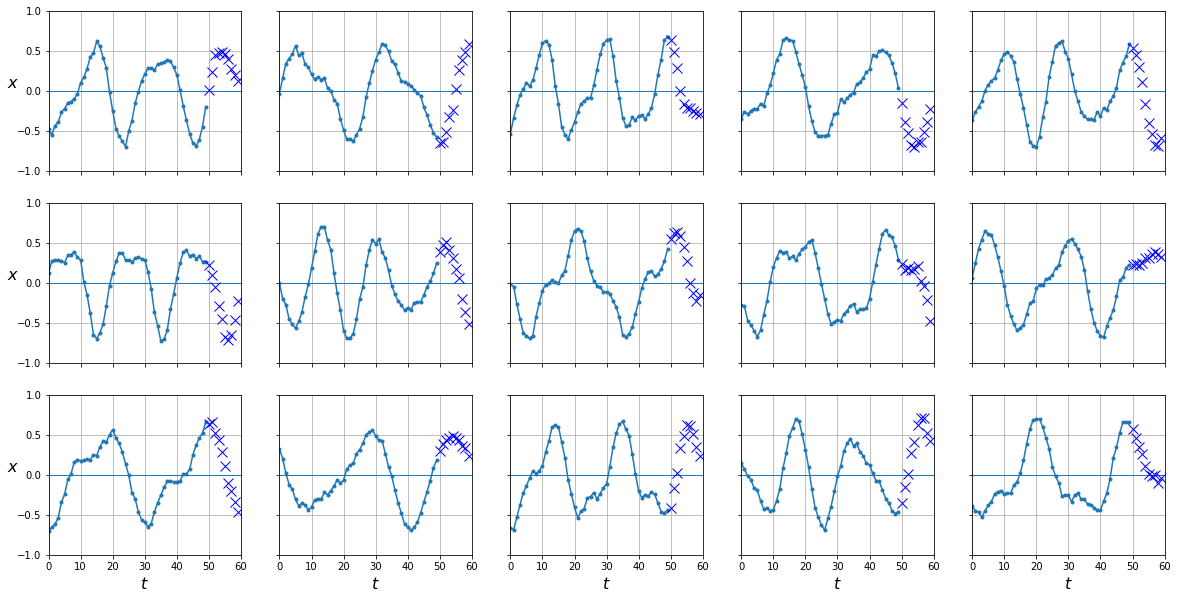

In [161]:
plot_series(X_test, y_test)

In [162]:
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64), ## train tiene shuffle true
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

#### Se define un MLP con fines de comparación

In [163]:
class MLP(torch.nn.Module):
  def __init__(self, n_in=n_steps, n_out=n_future):
    super().__init__()
    self.fc = torch.nn.Linear(n_in, n_out)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

# n_steps y out_future definidos arriba
mlp = MLP(n_steps, n_future)
mlp

MLP(
  (fc): Linear(in_features=50, out_features=10, bias=True)
)

In [164]:
fit(mlp, dataloader) #dataloader define como entran los datos

epoch numero:  0


valid_loss 0.06689: 100%|██████████| 32/32 [00:00<00:00, 412.86it/s]


epoch numero:  1


valid_loss 0.04898: 100%|██████████| 32/32 [00:00<00:00, 386.76it/s]


epoch numero:  2


valid_loss 0.04032: 100%|██████████| 32/32 [00:00<00:00, 397.10it/s]


epoch numero:  3


valid_loss 0.03546: 100%|██████████| 32/32 [00:00<00:00, 343.19it/s]


epoch numero:  4


valid_loss 0.03224: 100%|██████████| 32/32 [00:00<00:00, 380.01it/s]


epoch numero:  5


valid_loss 0.02996: 100%|██████████| 32/32 [00:00<00:00, 350.71it/s]


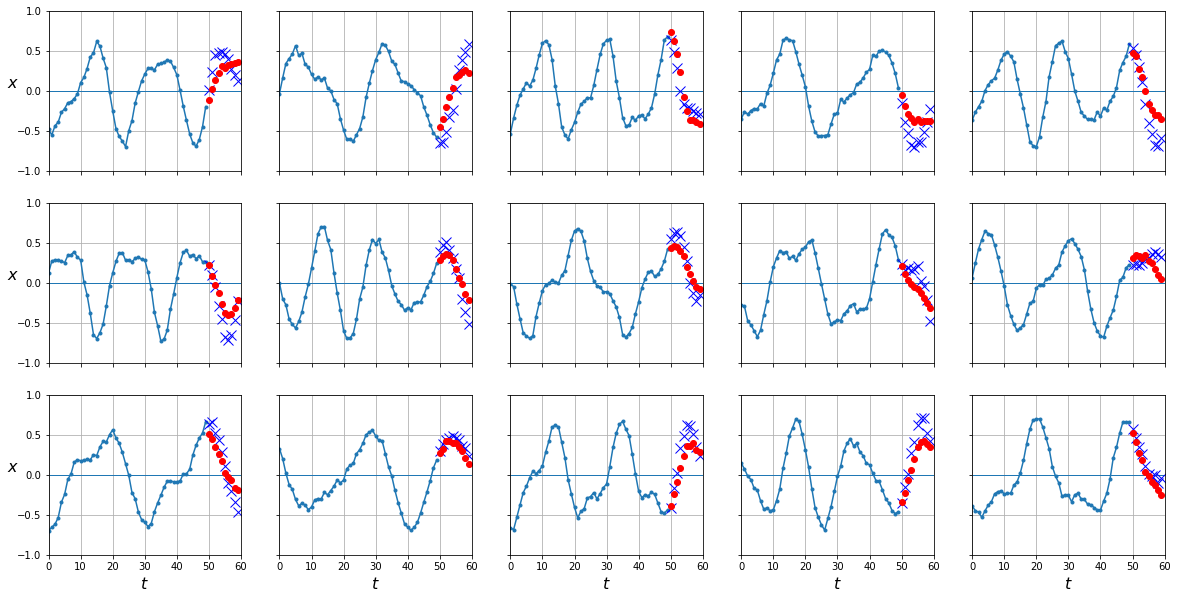

y_test shape:
(1000, 10, 1)
y_pred shape:
torch.Size([1000, 10])
Error cuadratico medio de la estimación final: 


0.031013161

In [165]:
y_pred = predict(mlp, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred)

#### para MLP MSE=0.0313, partimos de este punto

## Veamos ahora una RNN básica de 1 sola neurona

In [166]:
class SimpleRNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=1, num_layers=1, batch_first=True)
    self.fc=torch.nn.Linear(1,10)

  def forward(self, x):
    x, h = self.rnn(x) 
    y=self.fc(x[:,-1])   #modificar esta parte
    # solo queremos la última salidas
    #return x[:,-10:]
    #return x[:,-1:,-1]
    return y 

rnn = SimpleRNN()
rnn

SimpleRNN(
  (rnn): RNN(1, 1, batch_first=True)
  (fc): Linear(in_features=1, out_features=10, bias=True)
)

In [167]:
# veamos que arroja nuestra rnn ###modificar esto

entrada = torch.rand(50)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :, None]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([0.1385, 0.3312, 0.5755, 0.9949, 0.3273, 0.2907, 0.5829, 0.9356, 0.2492,
        0.9677, 0.3180, 0.1461, 0.9226, 0.6370, 0.3037, 0.1761, 0.0642, 0.7295,
        0.2473, 0.0688, 0.1736, 0.3124, 0.3598, 0.9808, 0.3474, 0.5733, 0.2093,
        0.1928, 0.5426, 0.8178, 0.6444, 0.1853, 0.8182, 0.5613, 0.3520, 0.8936,
        0.6417, 0.7221, 0.1203, 0.5739, 0.5293, 0.3120, 0.8545, 0.3168, 0.9524,
        0.6749, 0.4651, 0.7553, 0.6469, 0.7898])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 50, 1])

In [168]:
# veamos que arroja nuestra rnn

entrada = torch.rand(50)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :, None]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([0.0790, 0.9022, 0.0350, 0.0957, 0.3346, 0.6524, 0.5441, 0.1427, 0.7654,
        0.7671, 0.2457, 0.6496, 0.7679, 0.8237, 0.5842, 0.8785, 0.7279, 0.4783,
        0.7188, 0.2365, 0.3014, 0.9126, 0.0457, 0.4395, 0.3885, 0.4936, 0.9234,
        0.6660, 0.6212, 0.1636, 0.7116, 0.6178, 0.0254, 0.2013, 0.4259, 0.8984,
        0.0221, 0.0187, 0.2165, 0.2581, 0.4340, 0.9582, 0.6669, 0.3796, 0.0407,
        0.4279, 0.2803, 0.8583, 0.6603, 0.7419])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 50, 1])

In [169]:
# paso la entrada a la red
salida = rnn(entrada)

print('salida de la red (largo igual al input):')
print(salida)

print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[ 0.4774,  0.0299,  0.3784,  0.1475, -0.5651, -0.0660, -0.6229,  0.7977,
         -0.7578,  0.1621]], grad_fn=<AddmmBackward0>)
salida shape:
torch.Size([1, 10])


In [170]:
# ahora el vamos a pasar un set del dataset...

In [171]:

# veo primero una muestra del dataloader

xs, ys = next(iter(dataloader['train']))
print('tamaño del xs que le paso como input:')
print('batch x largo x nro features (si paso mas de 1 feature por tiempo)')
print(xs.shape)
print('---------')
print('tamaño del ys que le paso como input:')
print('batch x largo x nro features(si paso mas de 1 feature por tiempo)')
print(ys.shape)

tamaño del xs que le paso como input:
batch x largo x nro features (si paso mas de 1 feature por tiempo)
torch.Size([64, 50, 1])
---------
tamaño del ys que le paso como input:
batch x largo x nro features(si paso mas de 1 feature por tiempo)
torch.Size([64, 10, 1])


In [172]:
"""nr = 0
serie = xs[nr]
deseado = ys[nr]
print('input shape:')
print(serie.shape)
salida = rnn(serie[None,:])
print('salida de la red (largo igual al input):')
print(salida.shape)
print('tamaño del valor deseado:')
print(deseado.shape)"""


"nr = 0\nserie = xs[nr]\ndeseado = ys[nr]\nprint('input shape:')\nprint(serie.shape)\nsalida = rnn(serie[None,:])\nprint('salida de la red (largo igual al input):')\nprint(salida.shape)\nprint('tamaño del valor deseado:')\nprint(deseado.shape)"

In [173]:
fit(rnn, dataloader)

epoch numero:  0


valid_loss 0.32431: 100%|██████████| 32/32 [00:00<00:00, 287.41it/s]


epoch numero:  1


valid_loss 0.26523: 100%|██████████| 32/32 [00:00<00:00, 285.85it/s]


epoch numero:  2


valid_loss 0.22245: 100%|██████████| 32/32 [00:00<00:00, 287.61it/s]


epoch numero:  3


valid_loss 0.18710: 100%|██████████| 32/32 [00:00<00:00, 281.60it/s]


epoch numero:  4


valid_loss 0.15675: 100%|██████████| 32/32 [00:00<00:00, 283.63it/s]


epoch numero:  5


valid_loss 0.13971: 100%|██████████| 32/32 [00:00<00:00, 293.29it/s]


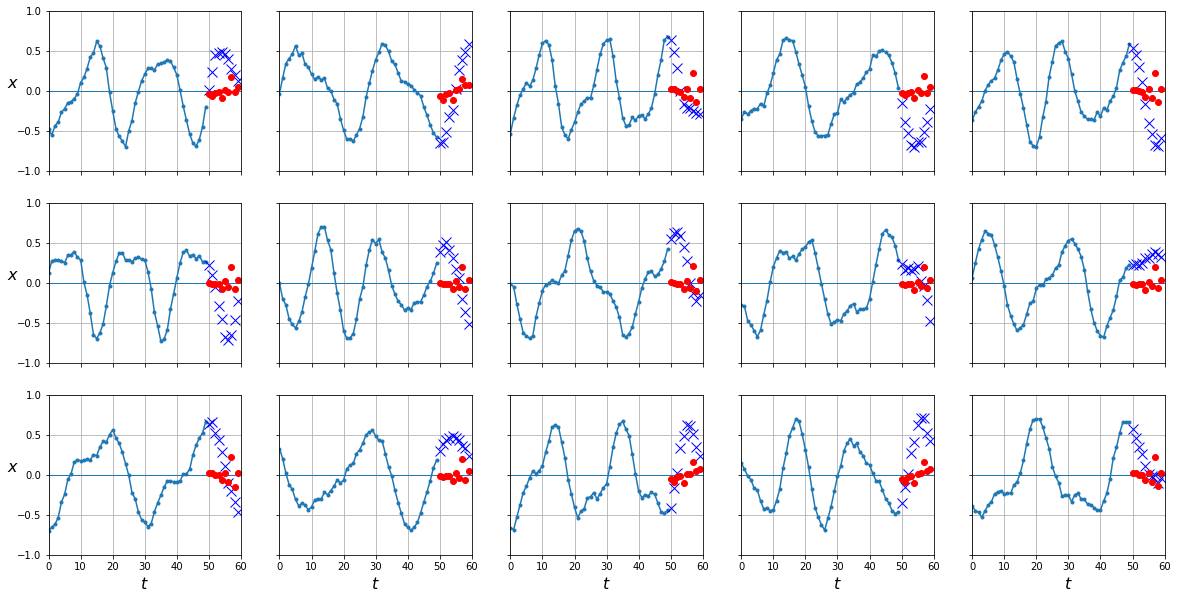

y_test shape:
(1000, 10, 1)
y_pred shape:
torch.Size([1000, 10])
Error cuadratico medio de la estimación final: 


0.14131194

In [174]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())


print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

## Comparacion de parámetros entre MLP y RNN implementada

In [175]:
# parámetros en el MLP

imp_param(mlp)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([10, 50])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([10])



In [176]:
# parámetros en el RNN

imp_param(rnn)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([1])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([1])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([10, 1])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([10])



## Incorporamos más neuronas en la RNN

In [177]:
class RNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(20, 10)

  def forward(self, x):
    x, h = self.rnn(x) 
    # get the last output and apply linear layer
    #print('x shape')
    #print(x.shape)
    #print('x shape [:,-1:]')
    #print(x[:,-1:].shape)
    y = self.fc(x[:,-1])
    
    return y

rnn_2 = RNN()

In [178]:
# parámetros en el RNN

imp_param(rnn_2)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([20, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([10, 20])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([10])



In [179]:
# veamos que arroja nuestra rnn_2
###entrada de 50 muestras###
entrada = torch.rand(50)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :, None]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([0.1015, 0.1648, 0.2347, 0.4474, 0.7656, 0.4273, 0.0632, 0.4288, 0.7211,
        0.4404, 0.0462, 0.2214, 0.0039, 0.9209, 0.9474, 0.1793, 0.7745, 0.5162,
        0.7716, 0.7722, 0.5392, 0.9955, 0.3410, 0.0458, 0.6286, 0.5699, 0.4364,
        0.6366, 0.7495, 0.1813, 0.3765, 0.5560, 0.8465, 0.4101, 0.1003, 0.5906,
        0.3303, 0.4592, 0.9064, 0.7828, 0.6087, 0.6283, 0.9397, 0.2137, 0.7778,
        0.2658, 0.0146, 0.2564, 0.7643, 0.0490])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 50, 1])

In [180]:
# paso la entrada a la red
salida = rnn_2(entrada)

print('salida de la red (largo igual al input):')
print(salida)
print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[-0.0815,  0.2086, -0.3023,  0.1448, -0.2323, -0.4039,  0.1743,  0.1239,
         -0.1993, -0.2033]], grad_fn=<AddmmBackward0>)
salida shape:
torch.Size([1, 10])


In [181]:
fit(rnn_2, dataloader)

epoch numero:  0


valid_loss 0.05122: 100%|██████████| 32/32 [00:00<00:00, 224.02it/s]


epoch numero:  1


valid_loss 0.04377: 100%|██████████| 32/32 [00:00<00:00, 222.84it/s]


epoch numero:  2


valid_loss 0.04233: 100%|██████████| 32/32 [00:00<00:00, 211.10it/s]


epoch numero:  3


valid_loss 0.04026: 100%|██████████| 32/32 [00:00<00:00, 200.69it/s]


epoch numero:  4


valid_loss 0.03805: 100%|██████████| 32/32 [00:00<00:00, 227.11it/s]


epoch numero:  5


valid_loss 0.03633: 100%|██████████| 32/32 [00:00<00:00, 217.63it/s]


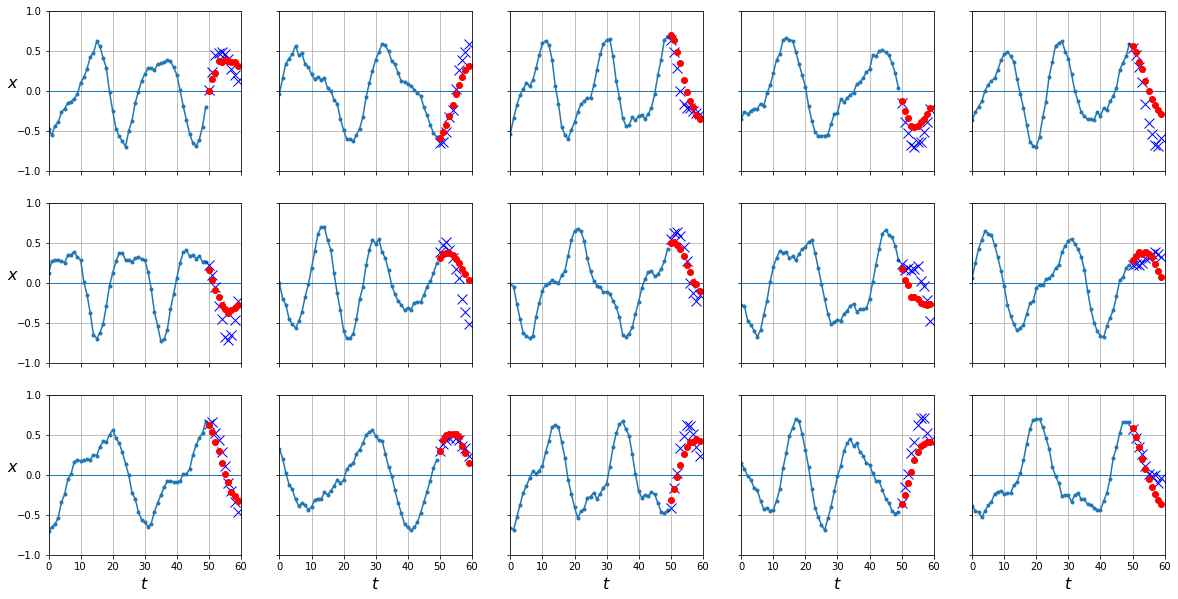

y_test shape:
(1000, 10, 1)
y_pred shape:
torch.Size([1000, 10])
Error cuadratico medio de la estimación final: 


0.036071397

In [182]:
y_pred = predict(rnn_2, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())


y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred.cpu())

## Le agregamos 1 layer mas, para tener mas profundidad





In [183]:
class DeepRNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, 10)

  def forward(self, x):
    x, h = self.rnn(x) 
    x = self.fc(x[:,-1])
    return x

In [184]:
rnn_deep = DeepRNN()
fit(rnn_deep, dataloader)

epoch numero:  0


valid_loss 0.05303: 100%|██████████| 32/32 [00:00<00:00, 146.61it/s]


epoch numero:  1


valid_loss 0.04189: 100%|██████████| 32/32 [00:00<00:00, 153.69it/s]


epoch numero:  2


valid_loss 0.03910: 100%|██████████| 32/32 [00:00<00:00, 150.79it/s]


epoch numero:  3


valid_loss 0.03340: 100%|██████████| 32/32 [00:00<00:00, 151.26it/s]


epoch numero:  4


valid_loss 0.03188: 100%|██████████| 32/32 [00:00<00:00, 153.19it/s]


epoch numero:  5


valid_loss 0.02837: 100%|██████████| 32/32 [00:00<00:00, 155.10it/s]


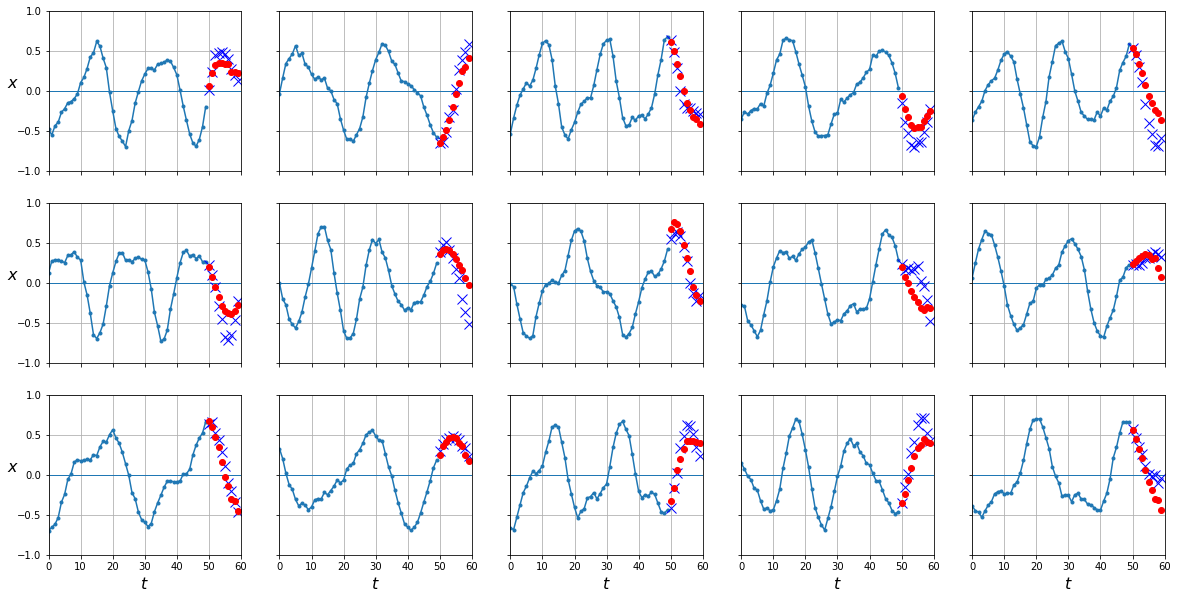

y_test shape:
(1000, 10, 1)
y_pred shape:
torch.Size([1000, 10])
Error cuadratico medio de la estimación final: 


0.027982563

In [185]:
y_pred = predict(rnn_deep, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

#### Este modelo ya mejoró  la metrica de MSE=0.0313>0.0276, vamos a intentar mejorar esto complejizando el modelo.

In [186]:
# parámetros en el RNN

imp_param(rnn_deep)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([20, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.weight_ih_l1
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.weight_hh_l1
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l1
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l1
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([10, 20])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([10])



#### Modelo de RNN con input_size=1, hidden_size=30, num_layers=4 llega a MSE=0.012454169. Mejoramos dos veces el desempeño al respecto de MLP

In [193]:
class DeepRNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=30, num_layers=4, batch_first=True)
    self.fc = torch.nn.Linear(30, 10)

  def forward(self, x):
    x, h = self.rnn(x) 
    x = self.fc(x[:,-1])
    return x

In [194]:
rnn_deep = DeepRNN()
fit(rnn_deep, dataloader)

epoch numero:  0


valid_loss 0.04521: 100%|██████████| 32/32 [00:00<00:00, 82.62it/s]


epoch numero:  1


valid_loss 0.02873: 100%|██████████| 32/32 [00:00<00:00, 85.04it/s]


epoch numero:  2


valid_loss 0.02555: 100%|██████████| 32/32 [00:00<00:00, 86.64it/s]


epoch numero:  3


valid_loss 0.01887: 100%|██████████| 32/32 [00:00<00:00, 71.90it/s]


epoch numero:  4


valid_loss 0.01507: 100%|██████████| 32/32 [00:00<00:00, 85.82it/s]


epoch numero:  5


valid_loss 0.01254: 100%|██████████| 32/32 [00:00<00:00, 73.82it/s]


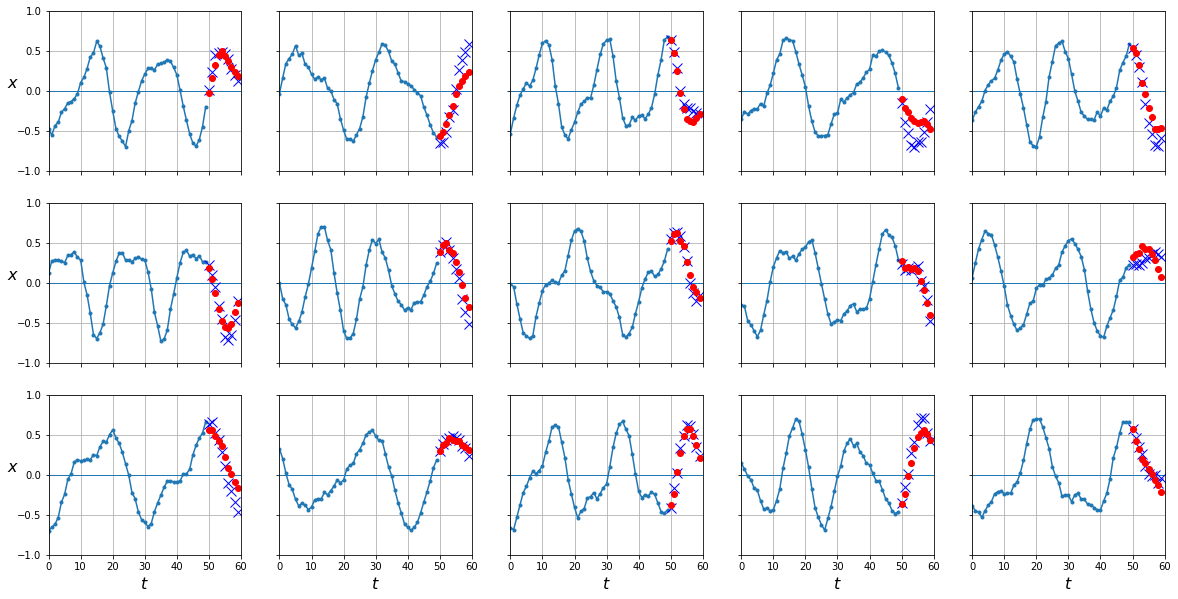

y_test shape:
(1000, 10, 1)
y_pred shape:
torch.Size([1000, 10])
Error cuadratico medio de la estimación final: 


0.012454169

In [195]:
y_pred = predict(rnn_deep, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

In [196]:
imp_param(rnn_deep)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([30, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([30, 30])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([30])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([30])

Nombre del parámetro: 
rnn.weight_ih_l1
Tamaño del parámetro: 
torch.Size([30, 30])

Nombre del parámetro: 
rnn.weight_hh_l1
Tamaño del parámetro: 
torch.Size([30, 30])

Nombre del parámetro: 
rnn.bias_ih_l1
Tamaño del parámetro: 
torch.Size([30])

Nombre del parámetro: 
rnn.bias_hh_l1
Tamaño del parámetro: 
torch.Size([30])

Nombre del parámetro: 
rnn.weight_ih_l2
Tamaño del parámetro: 
torch.Size([30, 30])

Nombre del parámetro: 
rnn.weight_hh_l2
Tamaño del parámetro: 
torch